# Figure 4B 

# Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from sympy import symbols, solve, simplify
import pandas as pd
from scipy.optimize import curve_fit
import sympy as sp
plt.rcParams.update({'font.size': 20})

# Definitions

Function to define the properties of the axis of a plot

In [2]:
def my_axsis(ax, xlim, ylim, xticks, title, xtickslabels, bold=True, scale='lin'):    
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_title(title)
    ax.set_xticklabels(xtickslabels)
    
    if bold==True:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.2)
            
    if scale=='log':
        ax.set_yscale('log', base=2)

# Model 

Definition of the parameters of the model

In [3]:
T, V1, V2, K1, K2, Kb = symbols('T V1 V2 K1 K2 Kb') 
Vs, Rb, Ks, Vrg, Qb, Krg = symbols('Vs Rb Ks Vrg Qb Krg')
R, F, Kd, Q, E, Ke = symbols('R F Kd Q E Ke')
S1, Qtot, S2, Rtot= symbols('S1 Qtot S2 Rtot')

The evolution equation for T

In [4]:
# Evolution equation for T: 
expr = V1*(1-T)/(K1+(1-T))-V2*T/(K2+T)-Kb*T
expr_simplified= V1*(1-T)*(K2+T) -V2*T*(K1+(1-T))-Kb*T*(K1+(1-T))*(K2+T)
print('Evolution equation for T:')
print(expr)

# Substitute the expression for V1 and V2 in the evolution equation for T:  
expr_RQ= expr_simplified.subs([(V1, Vs*(R*F/(Kd+F))/(Ks+(R*F/(Kd+F)))),(V2, Vrg*(Q*E/(Ke+E))/(Krg+(Q*E/(Ke+E))))])

# Substitute the expressions for Q and R
expr_S1S2 = expr_RQ.subs([(R, Rtot*S1),(Q, Qtot*S2)])

# Expliciting the relation between S1 and S2 to obtain T(FGF, S1): 
expr_T = expr_S1S2.subs([(S2,-1.1265*S1 +0.9092)])

print('Evolution equation for T (all parameters explicited):')
print(expr_T)

# Solve the equation 
sol = solve(expr_T, T)[2]

Evolution equation for T:
-Kb*T - T*V2/(K2 + T) + V1*(1 - T)/(K1 - T + 1)
Evolution equation for T (all parameters explicited):
-E*Qtot*T*Vrg*(0.9092 - 1.1265*S1)*(K1 - T + 1)/((E + Ke)*(E*Qtot*(0.9092 - 1.1265*S1)/(E + Ke) + Krg)) + F*Rtot*S1*Vs*(1 - T)*(K2 + T)/((F + Kd)*(F*Rtot*S1/(F + Kd) + Ks)) - Kb*T*(K2 + T)*(K1 - T + 1)


Definition of the function ExprT that compute T as a function of all the parameters of the equation

In [5]:
def exprT(Vs_v=1, Vrg_v=0.4, K1_v=0.5, K2_v=0.2, Krg_v=1200, Ks_v=1200, Kb_v=0.2, F_v=5, Kd_v=25, E_v=5, Ke_v=50, Rtot_v=2000, Qtot_v=2000, S1_v=0.5):
    sol_T = sol.subs([(Vs,Vs_v),(Vrg,Vrg_v),(K1, K1_v),(K2,K2_v),(Krg, Krg_v), (Ks, Ks_v), (Kb, Kb_v),(F, F_v),(Kd, Kd_v),(E,E_v), (Ke, Ke_v),(Rtot, Rtot_v),(Qtot,Qtot_v),(S1,S1_v)])
    sol_T = np.real(np.array(sol_T,complex))
    return sol_T

In [6]:
# Solve the equation 
sol_S1S2 = solve(expr_S1S2, T)[1]

def exprT_S1S2(Vs_v=1, Vrg_v=0.4, K1_v=0.5, K2_v=0.2, Krg_v=1200, Ks_v=1200, Kb_v=0.2, F_v=5, Kd_v=25, E_v=5, Ke_v=50, Rtot_v=2000, Qtot_v=2000, S1_v=0.5, S2_v= 0.4):
    sol_S= sol_S1S2.subs([(Vs,Vs_v),(Vrg,Vrg_v),(K1, K1_v),(K2,K2_v),(Krg, Krg_v), (Ks, Ks_v), (Kb, Kb_v),(F, F_v),(Kd, Kd_v),(E,E_v), (Ke, Ke_v),(Rtot, Rtot_v),(Qtot,Qtot_v),(S1,S1_v),(S2,S2_v)])
    sol_S = np.real(np.array(sol_S,complex))
    return sol_S

Definition of the function to compute Erk (as a function of T):

In [7]:
def Erk(T,n=2, Kerk=0.5, Erk_max=1, Erk_bas=0): 
    Erk = [ Erk_max* T[i]**n/(T[i]**n +Kerk**n)+Erk_bas for i in range(len(T)) ]
    return Erk

In [8]:
def Erk1D(T,n=2, Kerk=0.5, Erk_max=1, Erk_bas=0): 
    Erk = Erk_max* T**n/(T**n +Kerk**n) + Erk_bas
    return Erk

# Import the experimental data 

In [9]:
# Read the excel file with the experimental data
data_S1 = pd.read_excel('/Users/rossanabettoni/Desktop/PhD/Article_PLOS/ExpData.xlsx', sheet_name='Cell surface contacts')
df_S1 = pd.DataFrame(data_S1)

Experimental data figure 1C

In [10]:
# Reltive area of cell surface contact with FGF expressing cells (divided by cell type)
a65_RelContactArea_A = np.array(df_S1['a6.5 S1'].values.tolist())[0:25] 
a66_RelContactArea_A = np.array(df_S1['a6.6 S1'].values.tolist())[0:25] 
a67_RelContactArea_A = np.array(df_S1['a6.7 S1'].values.tolist())[0:25] 
a68_RelContactArea_A = np.array(df_S1['a6.8 S1'].values.tolist())[0:25] 

# Results 

## Figure 4B

Compute Erk activity and the mean values for each cell type (starting from S1 and S2 exp data)

In [11]:
# Compute T starting from the exp values of S1 
T_pred_a68 = [exprT(S1_v= a68_RelContactArea_A[i]) for i in range(len(a68_RelContactArea_A))]
T_pred_a66 = [exprT(S1_v= a66_RelContactArea_A[i]) for i in range(len(a68_RelContactArea_A))]
T_pred_a67 = [exprT(S1_v= a67_RelContactArea_A[i]) for i in range(len(a68_RelContactArea_A))]
T_pred_a65 = [exprT(S1_v= a65_RelContactArea_A[i]) for i in range(len(a68_RelContactArea_A))]

# Compute Erk*
Erk_pred_a68 = Erk(T_pred_a68)
Erk_pred_a66 = Erk(T_pred_a66)
Erk_pred_a67 = Erk(T_pred_a67)
Erk_pred_a65 = Erk(T_pred_a65)

# Compute the mean Erk value for each cell type (with our model)
mean_a65_Erk_model= np.mean(Erk_pred_a65) 
mean_a66_Erk_model= np.mean(Erk_pred_a66)
mean_a67_Erk_model= np.mean(Erk_pred_a67)
mean_a68_Erk_model= np.mean(Erk_pred_a68)
Erk_mean = [mean_a65_Erk_model, mean_a66_Erk_model, mean_a67_Erk_model, mean_a68_Erk_model]

Code to find the $S_1^*$ (and $S_2^*$) for which $Erk(S_1^*) = Erk_{mean}$ (for each cell type)

In [12]:
RelContactArea_A = [a65_RelContactArea_A, a66_RelContactArea_A, a67_RelContactArea_A, a68_RelContactArea_A]
S1_star = np.zeros(4)
Erk_check = np.zeros(4)

for j in range(4): 

    S1_min_exp = min(RelContactArea_A[j]) # Minimum exp value of S1
    S1_max_exp = max(RelContactArea_A[j]) # Maximum exp value of S1

    # Initialization of the variables
    diff = 1  
    S1_lim_min = S1_min_exp
    S1_lim_max = S1_max_exp

    while diff > 0.000001: 

        S1_test= np.linspace(S1_lim_min,S1_lim_max, 20)

        # Compute Erk for the i-element of S1_temp
        T_test = [exprT(S1_v= S1_test[i]) for i in range(len(S1_test))]
        Erk_test = Erk(T_test)

        # Compute the difference between the ith value of Erk_test and the mean mean_Erk_model
        x = [abs(Erk_test[i]- Erk_mean[j]) for i in range(len(Erk_test))]

        # Find the minimum 
        idx = x.index(min(x))
        S1_star[j] = S1_test[idx]

        diff = abs(Erk_mean[j] - Erk_test[idx])
        Erk_check[j] = Erk_test[idx]

        S1_lim_min = S1_test[idx - 3]
        S1_lim_max = S1_test[idx + 3]
        
# Compute S2* 
S2_star = [-1.1265*S1_star[i]+0.9092 for i in range(len(S1_star))]

 Define the dictionaries to link each parameter name to the corresponding parameter value

In [13]:
6# Parameters linked to T
parameter_names = ['Vs_v','Vrg_v','Ks_v','Krg_v','K1_v','K2_v','F_v','E_v','Kd_v','Ke_v','Rtot_v','Qtot_v','S1_v','S2_v','Kb_v']
parameter_values_standard = [1,0.4,1200, 1200, 0.5,0.2,5,5,25,50,2000,2000,0.5,0.5,0.2]
param = dict(zip(parameter_names,parameter_values_standard))
parameter_values_minus = [np.round(parameter_values_standard[i]- parameter_values_standard[i]/5,2) for i in range(len(parameter_values_standard))]
parameter_values_plus = [np.round(parameter_values_standard[i]+ parameter_values_standard[i]/5,2) for i in range(len(parameter_values_standard))]

print('Standard values of the parameters:')
for i in range(len(parameter_names)): 
    print(parameter_names[i], parameter_values_standard[i])

# Parameters linked to Erk
parameter_names_Erk = ['Kerk']
parameter_values_standard_Erk = [0.5]
param_Erk = dict(zip(parameter_names_Erk,parameter_values_standard_Erk))
parameter_values_minus_Erk = [np.round(parameter_values_standard_Erk[i]- parameter_values_standard_Erk[i]/5,2) for i in range(len(parameter_values_standard_Erk))]
parameter_values_plus_Erk = [np.round(parameter_values_standard_Erk[i]+ parameter_values_standard_Erk[i]/5,2) for i in range(len(parameter_values_standard_Erk))]

# Define the standard values of the parameters for each cell type
parameter_values_standard_a68 = [1,0.4,1200, 1200, 0.5,0.2,5,5,25,50,2000,2000,S1_star[3], S2_star[3], 0.2]
parameter_values_standard_a66 = [1,0.4,1200, 1200, 0.5,0.2,5,5,25,50,2000,2000,S1_star[1], S2_star[1], 0.2]
parameter_values_standard_a67 = [1,0.4,1200, 1200, 0.5,0.2,5,5,25,50,2000,2000,S1_star[2], S2_star[2], 0.2]
parameter_values_standard_a65 = [1,0.4,1200, 1200, 0.5,0.2,5,5,25,50,2000,2000,S1_star[0], S2_star[0], 0.2]

# Define the standard values of the parameters ± 20% for each cell type
parameter_values_minus_a68 = [np.round(parameter_values_standard_a68[i]- parameter_values_standard_a68[i]/5,8) for i in range(len(parameter_values_standard))]
parameter_values_minus_a66 = [np.round(parameter_values_standard_a66[i]- parameter_values_standard_a66[i]/5,8) for i in range(len(parameter_values_standard))]
parameter_values_minus_a67 = [np.round(parameter_values_standard_a67[i]- parameter_values_standard_a67[i]/5,8) for i in range(len(parameter_values_standard))]
parameter_values_minus_a65 = [np.round(parameter_values_standard_a65[i]- parameter_values_standard_a65[i]/5,8) for i in range(len(parameter_values_standard))]

parameter_values_plus_a68 = [np.round(parameter_values_standard_a68[i]+ parameter_values_standard_a68[i]/5,8) for i in range(len(parameter_values_standard))]
parameter_values_plus_a66 = [np.round(parameter_values_standard_a66[i]+ parameter_values_standard_a66[i]/5,8) for i in range(len(parameter_values_standard))]
parameter_values_plus_a67 = [np.round(parameter_values_standard_a67[i]+ parameter_values_standard_a67[i]/5,8) for i in range(len(parameter_values_standard))]
parameter_values_plus_a65 = [np.round(parameter_values_standard_a65[i]+ parameter_values_standard_a65[i]/5,8) for i in range(len(parameter_values_standard))]

Standard values of the parameters:
Vs_v 1
Vrg_v 0.4
Ks_v 1200
Krg_v 1200
K1_v 0.5
K2_v 0.2
F_v 5
E_v 5
Kd_v 25
Ke_v 50
Rtot_v 2000
Qtot_v 2000
S1_v 0.5
S2_v 0.5
Kb_v 0.2


### Effect of changing the value of the parameters by ± 20%

Compute level of Erk when parameter values = standard values - 20%

In [14]:
Erk_output_a68_minus = np.zeros(len(parameter_names)+len(parameter_names_Erk)+1)
Erk_output_a66_minus = np.zeros(len(parameter_names)+len(parameter_names_Erk)+1)
Erk_output_a67_minus = np.zeros(len(parameter_names)+len(parameter_names_Erk)+1)
Erk_output_a65_minus = np.zeros(len(parameter_names)+len(parameter_names_Erk)+1)

# Cell a68
for i in range(len(parameter_names)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a68))
    param_temp[parameter_names[i]] = parameter_values_minus_a68[i]
    T_pred_S1star = exprT_S1S2(**param_temp)
    Erk_output_a68_minus[i] = Erk1D(T_pred_S1star)
    
for i in range(len(parameter_names_Erk)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a68))
    T_pred_S1star = exprT_S1S2(**param_temp)
    
    param_temp_Erk = dict(zip(parameter_names_Erk,parameter_values_standard_Erk))
    param_temp_Erk[parameter_names_Erk[i]] = parameter_values_minus_Erk[i]   
    Erk_output_a68_minus[i+len(parameter_names)] = Erk1D(T=T_pred_S1star,**param_temp_Erk)
    
# Cell a66  
for i in range(len(parameter_names)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a66))
    param_temp[parameter_names[i]] = parameter_values_minus_a66[i]
    T_pred_S1star = exprT_S1S2(**param_temp)
    Erk_output_a66_minus[i] = Erk1D(T_pred_S1star)
    
for i in range(len(parameter_names_Erk)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a66))
    T_pred_S1star = exprT_S1S2(**param_temp)
    
    param_temp_Erk = dict(zip(parameter_names_Erk,parameter_values_standard_Erk))
    param_temp_Erk[parameter_names_Erk[i]] = parameter_values_minus_Erk[i]   
    Erk_output_a66_minus[i+len(parameter_names)] = Erk1D(T=T_pred_S1star,**param_temp_Erk)

# Cell a67
for i in range(len(parameter_names)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a67))
    param_temp[parameter_names[i]] = parameter_values_minus_a67[i]
    T_pred_S1star = exprT_S1S2(**param_temp)
    Erk_output_a67_minus[i] = Erk1D(T_pred_S1star)

for i in range(len(parameter_names_Erk)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a67))
    T_pred_S1star = exprT_S1S2(**param_temp)
    
    param_temp_Erk = dict(zip(parameter_names_Erk,parameter_values_standard_Erk))
    param_temp_Erk[parameter_names_Erk[i]] = parameter_values_minus_Erk[i]   
    Erk_output_a67_minus[i+len(parameter_names)] = Erk1D(T=T_pred_S1star,**param_temp_Erk)

# Cell a65
for i in range(len(parameter_names)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a65))
    param_temp[parameter_names[i]] = parameter_values_minus_a65[i]
    T_pred_S1star = exprT_S1S2(**param_temp)
    Erk_output_a65_minus[i] = Erk1D(T_pred_S1star)
    
for i in range(len(parameter_names_Erk)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a65))
    T_pred_S1star = exprT_S1S2(**param_temp)
    
    param_temp_Erk = dict(zip(parameter_names_Erk,parameter_values_standard_Erk))
    param_temp_Erk[parameter_names_Erk[i]] = parameter_values_minus_Erk[i]   
    Erk_output_a65_minus[i+len(parameter_names)] = Erk1D(T=T_pred_S1star,**param_temp_Erk)

Compute level of Erk when parameter values = standard values + 20%

In [15]:
Erk_output_a68_plus = np.zeros(len(parameter_names)+len(parameter_names_Erk)+1)
Erk_output_a66_plus = np.zeros(len(parameter_names)+len(parameter_names_Erk)+1)
Erk_output_a67_plus = np.zeros(len(parameter_names)+len(parameter_names_Erk)+1)
Erk_output_a65_plus = np.zeros(len(parameter_names)+len(parameter_names_Erk)+1)

# Cell a68
for i in range(len(parameter_names)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a68))
    param_temp[parameter_names[i]] = parameter_values_plus_a68[i]
    T_pred_S1star = exprT_S1S2(**param_temp)
    Erk_output_a68_plus[i] = Erk1D(T_pred_S1star)
    
for i in range(len(parameter_names_Erk)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a68))
    T_pred_S1star = exprT_S1S2(**param_temp)
    
    param_temp_Erk = dict(zip(parameter_names_Erk,parameter_values_standard_Erk))
    param_temp_Erk[parameter_names_Erk[i]] = parameter_values_plus_Erk[i]   
    Erk_output_a68_plus[i+len(parameter_names)] = Erk1D(T=T_pred_S1star,**param_temp_Erk)

# Cell a66  
for i in range(len(parameter_names)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a66))
    param_temp[parameter_names[i]] = parameter_values_plus_a66[i]
    T_pred_S1star = exprT_S1S2(**param_temp)
    Erk_output_a66_plus[i] = Erk1D(T_pred_S1star)
    
for i in range(len(parameter_names_Erk)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a66))
    T_pred_S1star = exprT_S1S2(**param_temp)
    
    param_temp_Erk = dict(zip(parameter_names_Erk,parameter_values_standard_Erk))
    param_temp_Erk[parameter_names_Erk[i]] = parameter_values_plus_Erk[i]   
    Erk_output_a66_plus[i+len(parameter_names)] = Erk1D(T=T_pred_S1star,**param_temp_Erk)

# Cell a67
for i in range(len(parameter_names)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a67))
    param_temp[parameter_names[i]] = parameter_values_plus_a67[i]
    T_pred_S1star = exprT_S1S2(**param_temp)
    Erk_output_a67_plus[i] = Erk1D(T_pred_S1star)
    
for i in range(len(parameter_names_Erk)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a67))
    T_pred_S1star = exprT_S1S2(**param_temp)
    
    param_temp_Erk = dict(zip(parameter_names_Erk,parameter_values_standard_Erk))
    param_temp_Erk[parameter_names_Erk[i]] = parameter_values_plus_Erk[i]   
    Erk_output_a67_plus[i+len(parameter_names)] = Erk1D(T=T_pred_S1star,**param_temp_Erk)

# Cell a65
for i in range(len(parameter_names)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a65))
    param_temp[parameter_names[i]] = parameter_values_plus_a65[i]
    T_pred_S1star = exprT_S1S2(**param_temp)
    Erk_output_a65_plus[i] = Erk1D(T_pred_S1star)

for i in range(len(parameter_names_Erk)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a65))
    T_pred_S1star = exprT_S1S2(**param_temp)
    
    param_temp_Erk = dict(zip(parameter_names_Erk,parameter_values_standard_Erk))
    param_temp_Erk[parameter_names_Erk[i]] = parameter_values_plus_Erk[i]   
    Erk_output_a65_plus[i+len(parameter_names)] = Erk1D(T=T_pred_S1star,**param_temp_Erk)

### Effect of varying the relation between $S_1$ and $S_2$ ($S_2=-a*S_1+b $) on the level of Erk: 
we changed the value of $a$ by $\pm 20 \%$ ($a'=a\pm 20 \%$) and fit the experimental data with the relation $S_2=-a'*S_1+b$ to find the best value for $b$

In [16]:
Erk_output_a68_plus[ len(Erk_output_a68_plus)-1] = 0.00197901520436955
Erk_output_a66_plus[ len(Erk_output_a66_plus)-1] = 0.007583069185105231
Erk_output_a67_plus[ len(Erk_output_a67_plus)-1] = 0.055531136182824695 
Erk_output_a65_plus[ len(Erk_output_a65_plus)-1] = 0.18549250276434295 

Erk_output_a68_minus[ len(Erk_output_a68_minus)-1] = 0.0021160662369115826
Erk_output_a66_minus[ len(Erk_output_a66_minus)-1] = 0.007939732744713136
Erk_output_a67_minus[ len(Erk_output_a67_minus)-1] = 0.05459426472807974
Erk_output_a65_minus[ len(Erk_output_a65_minus)-1] = 0.17236376225632333

### Figure

In [17]:
parameter_names_fig = ['$V_s$','$V_{rg}$','$K_s$','$K_{rg}$','$K_1$','$K_2$','[FGF]','[eph]','$K_d$','$K_e$','$R_{tot}$','$Q_{tot}$','$S_1$', '$S_2$','$K_b$', '$K_{erk}$', '$S_2(S_1)$']
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

In [18]:
# Normalization
Erk_output_a68_plus_n = [Erk_output_a68_plus[i]/Erk_mean[3] for i in range(len(Erk_output_a68_plus))]
Erk_output_a68_minus_n = [Erk_output_a68_minus[i]/Erk_mean[3] for i in range(len(Erk_output_a68_minus))]

Erk_output_a66_plus_n = [Erk_output_a66_plus[i]/Erk_mean[1] for i in range(len(Erk_output_a66_plus))]
Erk_output_a66_minus_n = [Erk_output_a66_minus[i]/Erk_mean[1] for i in range(len(Erk_output_a66_minus))]

Erk_output_a67_plus_n = [Erk_output_a67_plus[i]/Erk_mean[2] for i in range(len(Erk_output_a67_plus))]
Erk_output_a67_minus_n = [Erk_output_a67_minus[i]/Erk_mean[2] for i in range(len(Erk_output_a67_minus))]

Erk_output_a65_plus_n = [Erk_output_a65_plus[i]/Erk_mean[0] for i in range(len(Erk_output_a65_plus))]
Erk_output_a65_minus_n = [Erk_output_a65_minus[i]/Erk_mean[0] for i in range(len(Erk_output_a65_minus))]

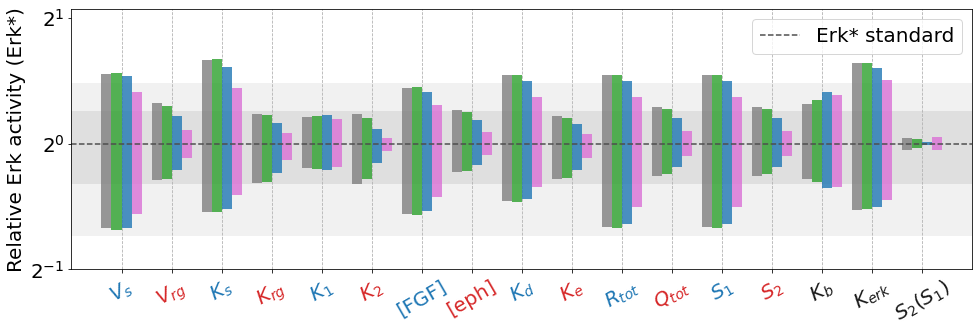

In [19]:
Erk_min_a65_fig = np.zeros(len(Erk_output_a65_minus))
Erk_min_a66_fig = np.zeros(len(Erk_output_a66_minus))
Erk_min_a67_fig = np.zeros(len(Erk_output_a67_minus))
Erk_min_a68_fig = np.zeros(len(Erk_output_a68_minus))

Erk_max_a65_fig = np.zeros(len(Erk_output_a65_minus))
Erk_max_a66_fig = np.zeros(len(Erk_output_a66_minus))
Erk_max_a67_fig = np.zeros(len(Erk_output_a67_minus))
Erk_max_a68_fig = np.zeros(len(Erk_output_a68_minus))

for i in range(len(Erk_output_a68_minus_n)): 
    if  Erk_output_a68_minus_n[i] > Erk_output_a68_plus_n[i]: 
        Erk_max_a68_fig[i] = Erk_output_a68_minus_n[i]
        Erk_min_a68_fig[i] = Erk_output_a68_plus_n[i]
    else:
        Erk_max_a68_fig[i] = Erk_output_a68_plus_n[i]
        Erk_min_a68_fig[i] = Erk_output_a68_minus_n[i]

for i in range(len(Erk_output_a66_minus_n)): 
    if  Erk_output_a66_minus_n[i] > Erk_output_a66_plus_n[i]: 
        Erk_max_a66_fig[i] = Erk_output_a66_minus_n[i]
        Erk_min_a66_fig[i] = Erk_output_a66_plus_n[i]
    else:
        Erk_max_a66_fig[i] = Erk_output_a66_plus_n[i]
        Erk_min_a66_fig[i] = Erk_output_a66_minus_n[i]

for i in range(len(Erk_output_a67_minus_n)): 
    if  Erk_output_a67_minus_n[i] > Erk_output_a67_plus_n[i]: 
        Erk_max_a67_fig[i] = Erk_output_a67_minus_n[i]
        Erk_min_a67_fig[i] = Erk_output_a67_plus_n[i]
    else:
        Erk_max_a67_fig[i] = Erk_output_a67_plus_n[i]
        Erk_min_a67_fig[i] = Erk_output_a67_minus_n[i]
        
for i in range(len(Erk_output_a65_minus_n)): 
    if  Erk_output_a65_minus_n[i] > Erk_output_a65_plus_n[i]: 
        Erk_max_a65_fig[i] = Erk_output_a65_minus_n[i]
        Erk_min_a65_fig[i] = Erk_output_a65_plus_n[i]
    else:
        Erk_max_a65_fig[i] = Erk_output_a65_plus_n[i]
        Erk_min_a65_fig[i] = Erk_output_a65_minus_n[i]
        

# Figure
height_fig_a68 = [Erk_max_a68_fig[i]-Erk_min_a68_fig[i] for i in range(len(Erk_max_a68_fig))]
bottom_fig_a68 = [Erk_min_a68_fig[i] for i in range(len(Erk_min_a68_fig))]

height_fig_a66 = [Erk_max_a66_fig[i]-Erk_min_a66_fig[i] for i in range(len(Erk_max_a66_fig))]
bottom_fig_a66 = [Erk_min_a66_fig[i] for i in range(len(Erk_min_a66_fig))]

height_fig_a67 = [Erk_max_a67_fig[i]-Erk_min_a67_fig[i] for i in range(len(Erk_max_a67_fig))]
bottom_fig_a67 = [Erk_min_a67_fig[i] for i in range(len(Erk_min_a67_fig))]

height_fig_a65 = [Erk_max_a65_fig[i]-Erk_min_a65_fig[i] for i in range(len(Erk_max_a65_fig))]
bottom_fig_a65 = [Erk_min_a65_fig[i] for i in range(len(Erk_min_a65_fig))]

x_new = 2.5*x

plt.figure(figsize=(14,5))

plt.bar(x_new-0.75,height_fig_a68, width=0.5, bottom=bottom_fig_a68, color='tab:grey' , alpha=0.8, zorder=2)
plt.bar(x_new-0.25,height_fig_a66, width=0.5, bottom=bottom_fig_a66, color='tab:green', alpha=0.8, zorder=2 )
plt.bar(x_new+0.25,height_fig_a67, width=0.5, bottom=bottom_fig_a67, color='tab:blue', alpha=0.8, zorder=2 )
plt.bar(x_new+0.75,height_fig_a65, width=0.5, bottom=bottom_fig_a65, color='orchid', alpha=0.8, zorder=2 )

plt.axhline(y=1,linestyle='--',linewidth=1.5, color='0.3', label='Erk* standard')
plt.ylim([0.5, 2.1])
plt.ylabel('Relative Erk activity (Erk*)')
plt.xticks(x_new, parameter_names_fig, color='tab:red', rotation=30)
plt.yticks(rotation=0)

x_temp= np.linspace(-4,44)
plt.fill_between(x_temp, 0.8, 1.2,facecolor='tab:grey', alpha=0.15, zorder=1)
plt.xlim([-2.5, 42.5])

plt.fill_between(x_temp, 0.6, 1.4,facecolor='tab:grey', alpha=0.10, zorder=1)
plt.xlim([-2.5, 42.5])


for i in [0,2,4,6,8,10,12]:
    plt.gca().get_xticklabels()[i].set_color('tab:blue') 
    
for i in [14,15,16]:
    plt.gca().get_xticklabels()[i].set_color('0.1') 

plt.yscale('log', base=2)
plt.legend()
plt.tight_layout()
plt.gca().xaxis.grid(True, linestyle='dashed')
plt.show()